### все необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)

import os
import PIL

import librosa
import librosa.display

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### вспомогательные функции

In [3]:
IMAGE_TRAIN_PATH = "./data/train/image"
VOICE_TRAIN_PATH = "./data/train/voice"
IMAGE_TEST_PATH = "./data/test/image/"
VOICE_TEST_PATH = "./data/test/voice/"

def read_image(path):
    return PIL.Image.open(path).convert('L')

def load_wav(path):
    return librosa.load(path, sr=8000)

In [4]:
#выгрузка картинок в виде векторов
def extract_image_features(image_folder):
    image_vectors = []
    indices = []
    for image_name in os.listdir(image_folder):
        index = os.path.splitext(image_name)[0]
        indices.append(index)
        image = read_image(os.path.join(image_folder, image_name))
        image_vector = np.array(image).reshape(-1)
        image_vectors.append(image_vector)
    return pd.DataFrame({
        'index': indices,
        'image_vector': image_vectors,
    })

In [5]:
#выгрузка голосовых данных
def extract_voice_features(voice_folder, numcep=15, hop_length=256):
    voice_vectors = []
    indices = []
    durations = []
    
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
        durations.append(signal.size / float(sr))
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
        'duration' : durations #добавим новый признак длина аудио
    })

## Собираем датасет

In [6]:
df = extract_image_features(IMAGE_TRAIN_PATH).merge(
                    extract_voice_features(VOICE_TRAIN_PATH), on='index')
df['target'] = df['index'].apply(lambda x: int(x[:1]))
df = df.drop('index', axis=1)
df.head(5)

,image_vector,voice_vector,duration,target
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-255.82959, 38.15204, 51.84722, 13.130906, 14...",0.217750,2
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-409.89935, 127.17834, -21.689606, -17.540297...",0.223750,4
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-431.00018, 39.874836, 21.09296, -8.168608, -...",0.484500,7
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-202.18109, 57.301323, 48.47514, -5.4865746, ...",0.263125,6
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-395.6473, 109.2142, -1.4051617, -15.394623, ...",0.282125,2


## Новый признак: число абсолютно черных пикселей

In [7]:
df['N_zero'] = df['image_vector'].apply(lambda x: (x<1.0).astype(int).sum() )

In [8]:
#добавим нормализацию
df['N_zero'] = RobustScaler().fit_transform(
                        df.N_zero.values.reshape(-1,1)
                                            )

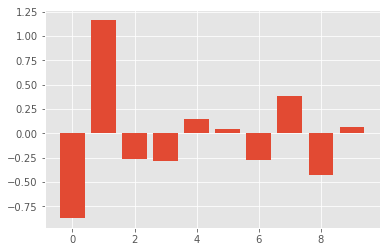

In [9]:
plt.bar(df.groupby('target')['N_zero'].mean().index,
        df.groupby('target')['N_zero'].mean().values
       );
#должно точно помочь отличать нули от единичек

## Новый признак: длина аудиозаписи

In [10]:
#еще нормализации
df['duration'] = RobustScaler().fit_transform(
                        df.duration.values.reshape(-1,1)
                                            )

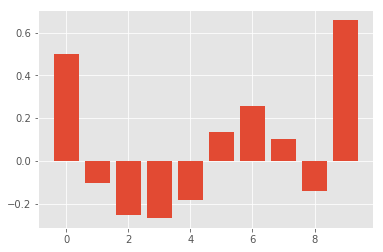

In [11]:
plt.bar(df.groupby('target')['duration'].mean().index,
        df.groupby('target')['duration'].mean().values
       );

In [12]:
df.head()

,image_vector,voice_vector,duration,target,N_zero
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-255.82959, 38.15204, 51.84722, 13.130906, 14...",-1.148272,2,-0.054545
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-409.89935, 127.17834, -21.689606, -17.540297...",-1.108288,4,0.600000
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-431.00018, 39.874836, 21.09296, -8.168608, -...",0.629321,7,0.781818
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-202.18109, 57.301323, 48.47514, -5.4865746, ...",-0.845898,6,-0.145455
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-395.6473, 109.2142, -1.4051617, -15.394623, ...",-0.719284,2,0.036364


### ещё один признак?

In [13]:
df['avg_mel'] = df['voice_vector'].apply(lambda x: x.mean() )

In [37]:
train_data, test_data = train_test_split(
    df, test_size=0.2, random_state=57
)

In [38]:
X_train = np.hstack((
    np.vstack(train_data["voice_vector"]),
    np.vstack(train_data["image_vector"]),
    np.vstack(train_data['N_zero']),
    np.vstack(train_data['duration'])
))
y_train = train_data["target"]

X_test = np.hstack((
    np.vstack(test_data["voice_vector"]),
    np.vstack(test_data["image_vector"]),
    np.vstack(test_data['N_zero']),
    np.vstack(test_data['duration'])
))
y_test = test_data["target"]

In [16]:
#для обучения на полном датасете
# X_train = np.hstack((
#     np.vstack(df["voice_vector"]),
#     np.vstack(df["image_vector"]),
#     np.vstack(df['N_zero']),
#     np.vstack(df['duration'])
# ))
# y_train = df["target"]

In [42]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=4).fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

In [43]:
clf.score(X_test, y_test)

0.9533333333333334

# Проверим различную степень сжатия вектора картинки

In [44]:
from sklearn.decomposition import PCA
img_vecs =  np.vstack(df["image_vector"])
voice_vecs = np.vstack(df["voice_vector"]) #дает плохие результаты не сжимаем

In [45]:
out = []
num_of_comp = [5, 7, 10, 12, 15, 20, 30, 60, 100, 200, 400, 500]
for n in num_of_comp:
    tmp = 0
    pca_image = PCA(n_components=n).fit(img_vecs)
    X_train = np.hstack((
        np.vstack(train_data["voice_vector"]),
        pca_image.transform(np.vstack(train_data["image_vector"])),
        np.vstack(train_data['N_zero']),
        np.vstack(train_data['duration'])
    ))
    y_train = train_data["target"]
    
    X_test = np.hstack((
        np.vstack(test_data["voice_vector"]),
        pca_image.transform(np.vstack(test_data["image_vector"])),
        np.vstack(test_data['N_zero']),
        np.vstack(test_data['duration'])
    ))
    y_test = test_data["target"]
    
    for i in range(5):
        
        clf = RandomForestClassifier(n_estimators=200, n_jobs=4).fit(X_train, y_train)
        tmp += clf.score(X_test, y_test)
        
    out.append(tmp/5.0)
    print(n, end='  ')

5  7  10  12  15  20  30  60  100  200  400  500  

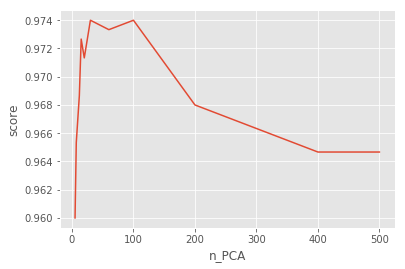

In [46]:
plt.plot(num_of_comp, out)
plt.xlabel('n_PCA')
plt.ylabel('score');

## Покрутим кол-во дереввьев

In [71]:
    pca_image = PCA(n_components=100).fit(img_vecs)
    X_train = np.hstack((
        np.vstack(train_data["voice_vector"]),
        pca_image.transform(np.vstack(train_data["image_vector"])),
        np.vstack(train_data['N_zero']),
        np.vstack(train_data['duration'])
    ))
    y_train = train_data["target"]
    
    X_test = np.hstack((
        np.vstack(test_data["voice_vector"]),
        pca_image.transform(np.vstack(test_data["image_vector"])),
        np.vstack(test_data['N_zero']),
        np.vstack(test_data['duration'])
    ))
    y_test = test_data["target"]

In [72]:
out = []
num_of_estimators = [120, 220, 250, 280, 300, 320, 380]

for n in num_of_estimators:
    tmp = 0
    for i in range(5):
        clf = RandomForestClassifier(n_estimators=n, n_jobs=4).fit(X_train, y_train)
        tmp += clf.score(X_test, y_test)
        
    out.append(tmp/5.0)
    print(n, end='  ')

120  220  250  280  300  320  380  

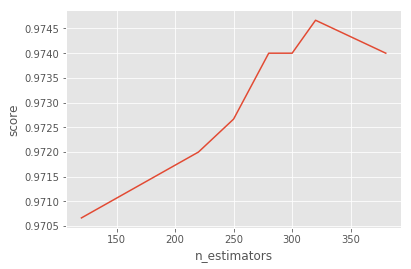

In [73]:
plt.plot(num_of_estimators, out)
plt.xlabel('n_estimators')
plt.ylabel('score');

In [74]:
clf = RandomForestClassifier(n_estimators=320, n_jobs=4).fit(X_train, y_train)

In [75]:
clf.score(X_train, y_train)

1.0

In [76]:
clf.score(X_test, y_test)

0.9766666666666667

## Посмотрим в целом на предсказания по классам цифр

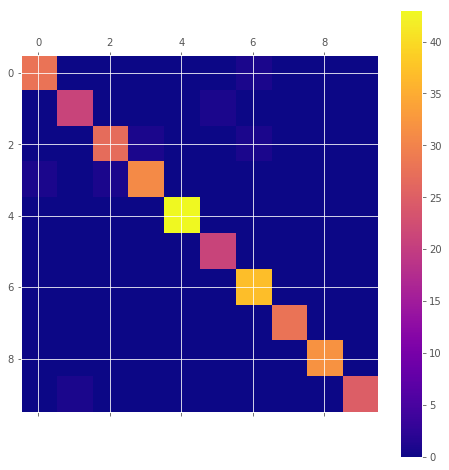

In [77]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))

plt.figure(figsize=(8,8))
plt.matshow(conf_matrix, cmap="plasma", fignum=1)
plt.colorbar();

## Попробуем логистическую регрессию

In [80]:
from sklearn.linear_model import LogisticRegression
ModelLR = LogisticRegression(C=30, solver='lbfgs', multi_class='multinomial')
ModelLR.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
ModelLR.score(X_test,y_test)

0.86

# Предсказания

In [82]:
df_pred = extract_image_features(IMAGE_TEST_PATH).merge(
                    extract_voice_features(VOICE_TEST_PATH), on='index')

In [83]:
df_pred['N_zero'] = df_pred['image_vector'].apply(lambda x: (x<1.0).astype(int).sum() )
df_pred['N_zero'] = RobustScaler().fit_transform(
                        df_pred.N_zero.values.reshape(-1,1)
                                            )
df_pred['duration'] = RobustScaler().fit_transform(
                        df_pred.duration.values.reshape(-1,1)
                                            )

In [84]:
X = np.hstack((
        np.vstack(df_pred["voice_vector"]),
        pca_image.transform(np.vstack(df_pred["image_vector"])),
        np.vstack(df_pred['N_zero']),
        np.vstack(df_pred['duration'])
))

In [85]:
df_pred['target'] = clf.predict(X)

In [86]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 6 columns):
index           500 non-null object
image_vector    500 non-null object
voice_vector    500 non-null object
duration        500 non-null float64
N_zero          500 non-null float64
target          500 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 27.3+ KB


In [87]:
df_pred[["index", "target"]].to_csv("pred/y_pred_08.csv", index=False)

!cat pred/y_pred_08.csv | head

index,target
144,2
402,3
102,3
121,1
397,3
27,9
194,6
381,3
320,2
